In this final notebook I load the scores from each of the models:
1) (Deterministic) PCA on levels,
2) Linear AE + SVD (of Plaut, 2018),
3) Deep AE,
4) VanillaVAE,

and regress using OLS the excess returns of a trading strategy holding 10-year maturity treasuries and selling the risk-free rate on each the scores to assess predictive in-sample fit:

$$
xret_{t+1}^{(10)} = \beta_0 + \beta_1C_{1t} + \beta_2C_{2t} + \beta_3C_{3t} + \epsilon_{t+1}.
$$

This baseline is commonly run in the finance literature to test the spanning hypothesis, see e.g., [Bauer and Hamilton, 2018].

In [7]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from stargazer.stargazer import Stargazer
from utils.data_utils import load_yield_data, calculate_excess_returns

yield_data = load_yield_data()
excess_returns = calculate_excess_returns(yield_data)

pca_scores = pd.read_csv(r'scores/pca_scores.csv', index_col=0, parse_dates=True)
ae_svd_scores = pd.read_csv(r'scores/ae_svd_scores.csv', index_col=0, parse_dates=True)
deep_ae_scores = pd.read_csv(r'scores/deep_ae_scores.csv', index_col=0, parse_dates=True)
vae_scores = pd.read_csv(r'scores/vae_scores.csv', index_col=0, parse_dates=True)

# Further experimental results
pca2d_scores = pd.read_csv(r'scores/pca2d_scores.csv', index_col=0, parse_dates=True)
vae2d_scores = pd.read_csv(r'scores/vae2d_scores.csv', index_col=0, parse_dates=True) # From 3b2DVAE.ipynb
pca5d_scores = pd.read_csv(r'scores/pca5d_scores.csv', index_col=0, parse_dates=True) 
vae5d_scores = pd.read_csv(r'scores/vae5d_scores.csv', index_col=0, parse_dates=True) # From 3c5DVAE.ipynb

# Time series of scores

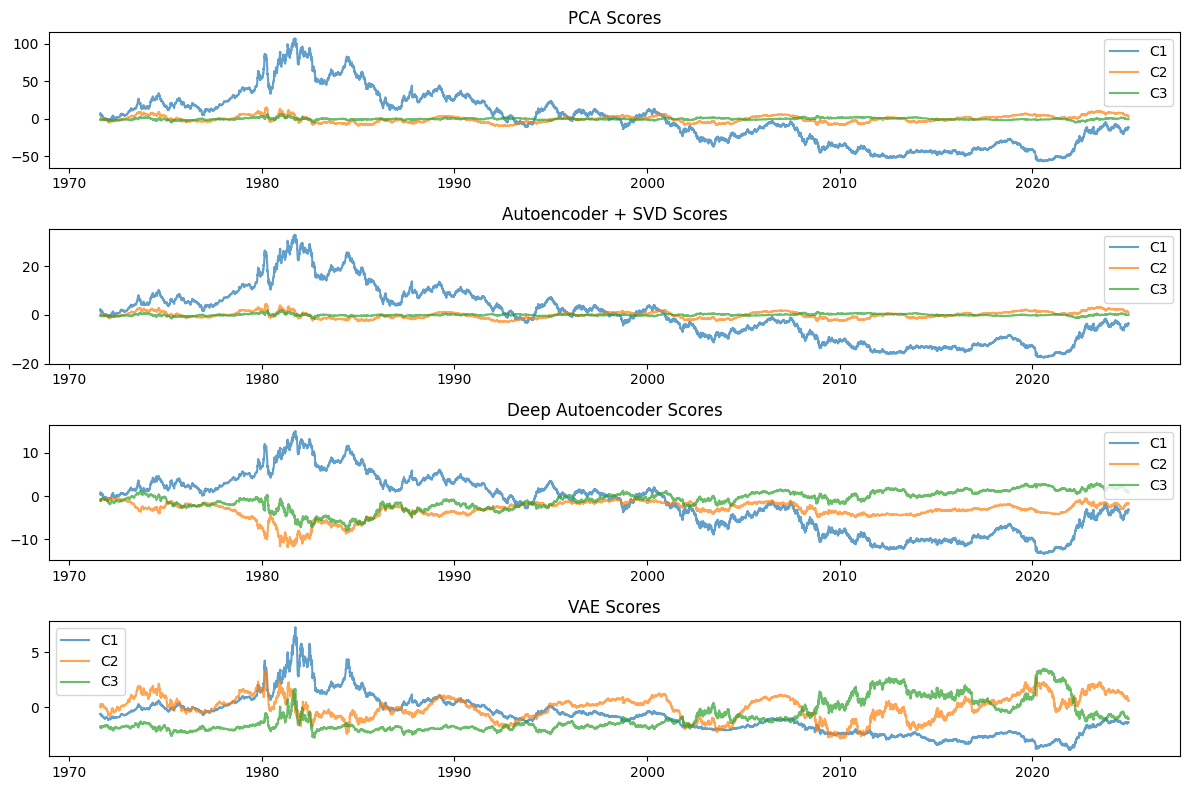

In [8]:
# Create a grid plot plotting each of the scores
fig, axes = plt.subplots(4, 1, figsize=(12, 8))
components = ['C1', 'C2', 'C3']
score_dfs = [pca_scores, ae_svd_scores, deep_ae_scores, vae_scores, vae2d_scores]
titles = ['PCA Scores', 'Autoencoder + SVD Scores', 'Deep Autoencoder Scores', 'VAE Scores']
for i, (score_df, title) in enumerate(zip(score_dfs, titles)):
    for comp in components:
        axes[i].plot(score_df.index, score_df[comp], label=comp, alpha=0.7)
    axes[i].set_title(title)
    axes[i].legend()
plt.tight_layout()
plt.show()

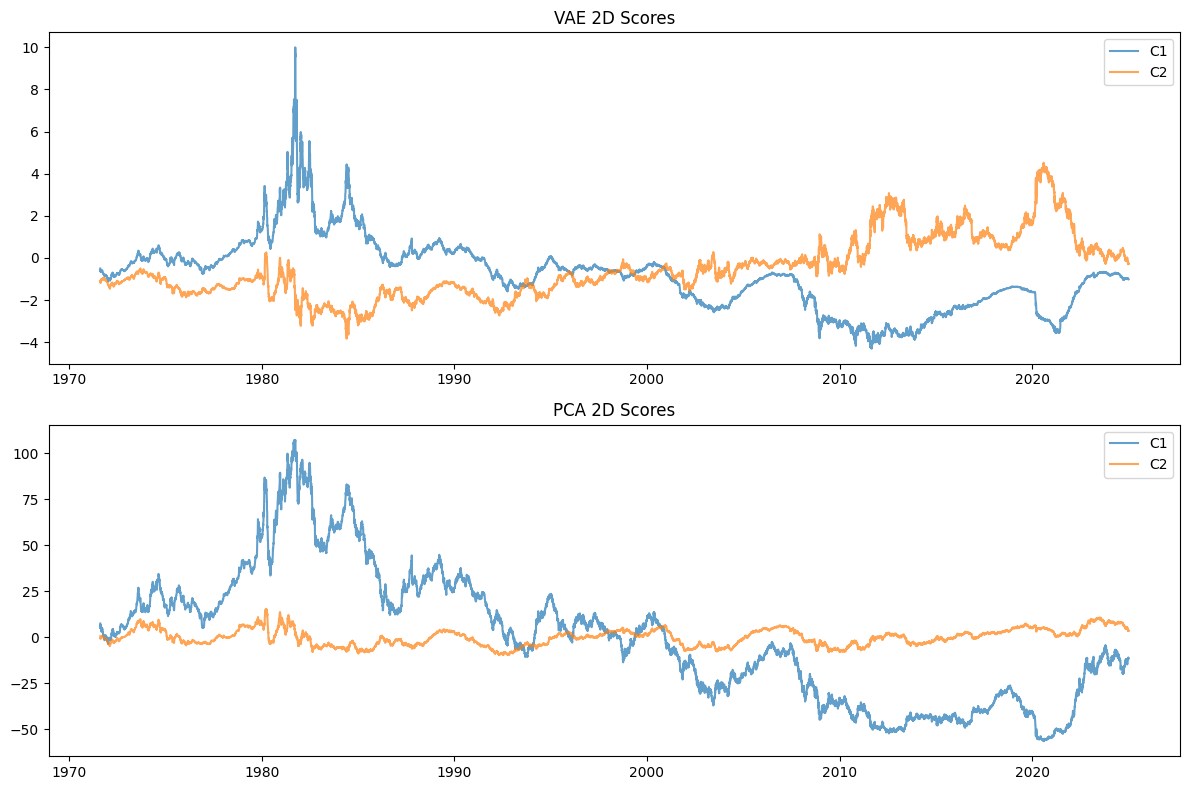

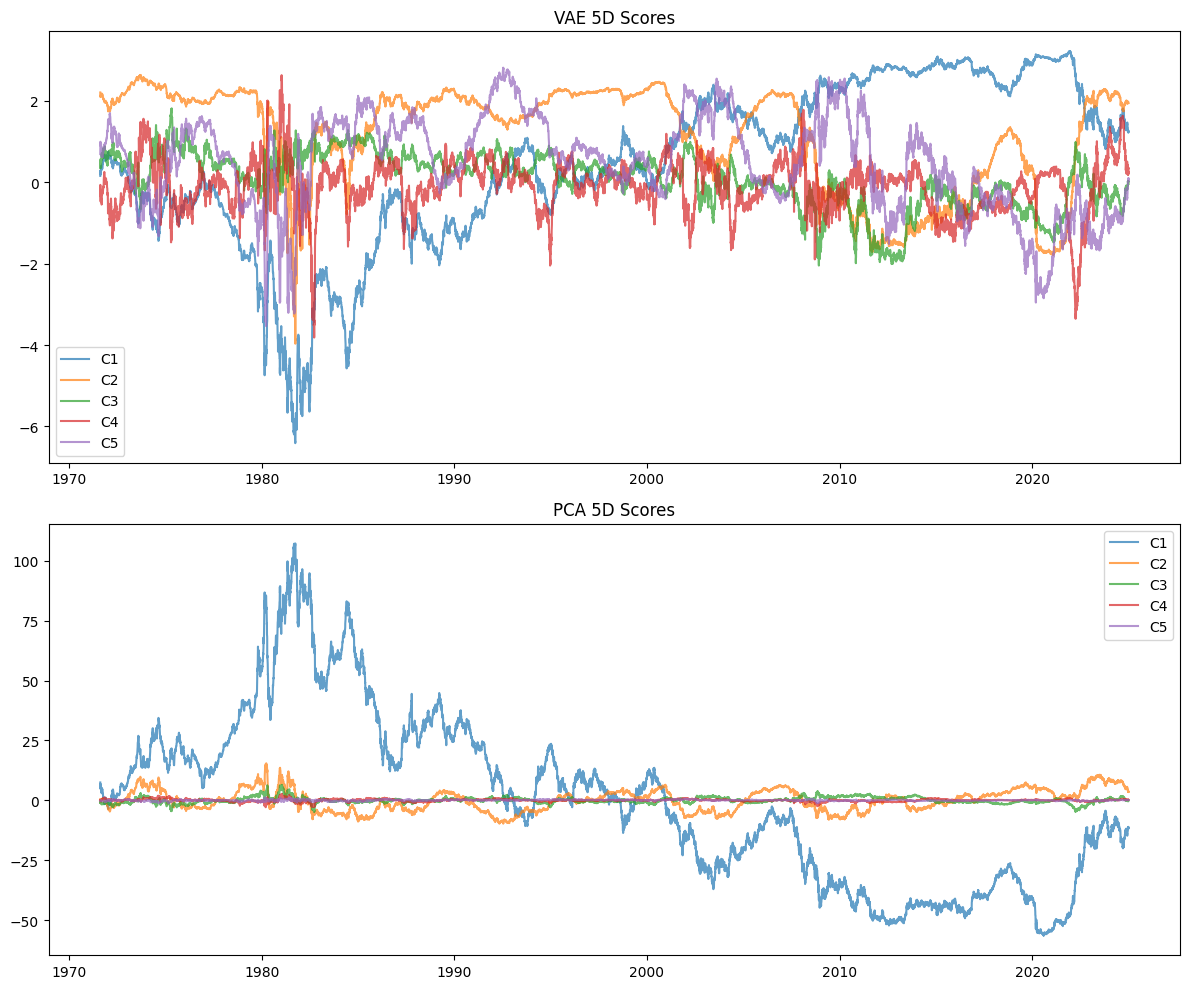

In [9]:
# Plot 2D VAE scores and 2D PCA scores against in subplots like above
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
# VAE 2D Scores
for comp in ['C1', 'C2']:
    axes[0].plot(vae2d_scores.index, vae2d_scores[comp], label=comp, alpha=0.7)
axes[0].set_title('VAE 2D Scores')
axes[0].legend()
# PCA 2D Scores
for comp in ['C1', 'C2']:
    axes[1].plot(pca2d_scores.index, pca2d_scores[comp], label=comp, alpha=0.7)
axes[1].set_title('PCA 2D Scores')
axes[1].legend()
plt.tight_layout()
plt.show()

# Plot 5D VAE scores and 5D PCA scores against in subplots like above
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
# VAE 5D Scores
for comp in ['C1', 'C2', 'C3', 'C4', 'C5']:
    axes[0].plot(vae5d_scores.index, vae5d_scores[comp], label=comp, alpha=0.7)
axes[0].set_title('VAE 5D Scores')
axes[0].legend()    
# PCA 5D Scores
for comp in ['C1', 'C2', 'C3', 'C4', 'C5']:
    axes[1].plot(pca5d_scores.index, pca5d_scores[comp], label=comp, alpha=0.7)
axes[1].set_title('PCA 5D Scores')
axes[1].legend()
plt.tight_layout()
plt.show()

# Predictive regressions and results

In [10]:
def run_predictive_regressions(excess_returns, score_dfs, model_names, dim=3):
    """Run in-sample predictive regressions of excess returns on latent factors.
    
    dim: number of latent components to use (2, 3, or 5).
    """
    results = []
    
    for scores, name in zip(score_dfs, model_names):
        # choose required columns based on dim
        if dim == 2:
            required_cols = ['C1', 'C2']
        elif dim == 3:
            required_cols = ['C1', 'C2', 'C3']
        elif dim == 5:
            required_cols = ['C1', 'C2', 'C3', 'C4', 'C5']
        else:
            raise ValueError("dim must be one of {2, 3, 5}")

        # ensure the score dataframe contains the required columns
        missing = [c for c in required_cols if c not in scores.columns]
        if missing:
            raise ValueError(f"Model '{name}' is missing required score columns: {missing}")

        # merge t+1 excess returns with t scores
        df = pd.merge(
            excess_returns[['xr_avg']].shift(-1),  # t+1 excess returns
            scores[required_cols],                 # t scores
            left_index=True,
            right_index=True,
            how='inner'
        ).dropna()

        # Build formula dynamically based on selected components
        formula = 'xr_avg ~ ' + ' + '.join(required_cols)
        model = smf.ols(formula, data=df).fit()
        results.append(model)
    
    return results

def display_stargazer_table(results, model_names, dim=3):
    """Display regression results in a clean Stargazer table."""
    stargazer = Stargazer(results)
    stargazer.custom_columns(model_names, [1] * len(model_names))
    stargazer.title("Predictive Regressions: 10-Year Excess Returns on Latent Factors")
    stargazer.show_model_numbers(False)

    # set covariate order based on dim
    covariates = ['Intercept'] + [f'C{i}' for i in range(1, dim+1)]
    stargazer.covariate_order(covariates)
    
    return stargazer

# Run regressions for all models (default using 3 components)
model_names3D = ['PCA', 'AE+SVD', 'Deep AE', 'VAE']
model_names2D = ['PCA 2D', 'VAE 2D']
model_names5D = ['PCA 5D', 'VAE 5D']
score_dfs3d = [pca_scores, ae_svd_scores, deep_ae_scores, vae_scores]
score_dfs2d = [pca2d_scores, vae2d_scores]
score_dfs5d = [pca5d_scores, vae5d_scores]
# specify dim explicitly (2, 3, or 5). Here we use 3 as in the original formula.
results = run_predictive_regressions(excess_returns, score_dfs3d, model_names3D, dim=3)

# Display comparison table
stargazer_table = display_stargazer_table(results, model_names3D, dim=3)
stargazer_table

In [11]:
# Report table for 2D models:
results_2d = run_predictive_regressions(excess_returns, score_dfs2d, model_names2D, dim=2)
stargazer_table_2d = display_stargazer_table(results_2d, model_names2D, dim=2)
stargazer_table_2d

In [12]:
# Report table for 5D models:
results5d = run_predictive_regressions(excess_returns, score_dfs5d, model_names5D, dim=5)
# Display comparison table
stargazer_table = display_stargazer_table(results5d, model_names5D, dim=5)
stargazer_table

Interestingly, in-sample $R^2$ does not improve over the three-component baseline, validating the three-factor models.

References:
* Bauer, Michael D., and James D. Hamilton. 2018. “Robust Bond Risk Premia.” The Review of Financial Studies 31(2):399–448. doi:10.1093/rfs/hhx096.